# Goal
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols


import scipy
import scipy as sp
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import f
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import plot_importance

from vecstack import stacking

from datetime import datetime
import pickle

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn')

%matplotlib inline

# Cleaning

In [2]:
df = pd.read_csv('student_data.csv')

In [3]:
df['default payment next month'].value_counts()

0    18691
1     5308
Name: default payment next month, dtype: int64

In [4]:
len(df)

23999

In [5]:
col_clean = []
for i in df.columns:
    col_clean.append(i.lower().strip().replace('_','').replace('default payment next month','default'))

In [6]:
df.columns = col_clean

In [7]:
df['limitstatus']=np.where(df.limitbal<550000, 0, 1)

In [8]:
df['boomer'] = np.where(df.age > 45, 1, 0)

In [9]:
df['ratio1'] = df.billamt1/(df.payamt1+1)

In [10]:
predictors = df.drop(columns=['default','id'])

In [11]:
target = df['default']

In [12]:
predictors

,limitbal,sex,education,marriage,age,pay0,pay2,pay3,pay4,pay5,pay6,billamt1,billamt2,billamt3,billamt4,billamt5,billamt6,payamt1,payamt2,payamt3,payamt4,payamt5,payamt6,limitstatus,boomer,ratio1
0,350000,1,1,2,37,-2,-2,-2,-2,-2,-2,316,316,316,466,466,316,316,316,466,466,316,316,0,0,0.996845
1,50000,2,2,1,37,2,2,2,0,0,0,40994,43594,38222,13026,13268,13497,5500,0,580,600,600,600,0,0,7.452100
2,50000,2,1,2,23,-1,-1,-1,-1,-1,-1,3430,2478,2299,4800,9810,660,2548,2321,4800,9810,660,2980,0,0,1.345626
3,20000,1,3,1,56,0,0,0,0,2,0,10847,12176,12884,13784,13420,13686,1508,1216,1116,0,490,658,0,1,7.188204
4,110000,2,2,2,32,0,0,0,0,0,0,108159,106812,108464,108829,110557,106082,5400,5400,4100,4100,4100,4200,0,0,20.025736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23994,50000,2,1,2,24,0,0,0,-2,-2,-2,12806,13490,0,0,0,0,7522,0,0,0,0,0,0,0,1.702246
23995,250000,1,3,1,44,-1,-1,-1,-1,-1,-1,6826,3900,4482,43546,38051,576,3924,4482,43676,38166,576,2389,0,0,1.739108
23996,50000,1,3,2,26,2,0,0,2,2,2,41827,42650,45930,44891,47654,48721,1800,4000,0,3500,2000,0,0,0,23.224320
23997,110000,2,2,1,38,0,0,0,0,0,0,195437,176420,63142,39854,9293,-1288,5000,10000,5048,2000,39958,52000,0,0,39.079584


## 2. EDA

## 3. Feature Engineering

## 4. Feature Selection

# 5. Model Fitting
KNN, Logistic Regression, Decision Tree

In [326]:
results = {}
results['model'] = ['accuracy', 'f1']

## Logistic

### Simple Logistic

In [217]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=0)

In [218]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced')

lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)


# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))


# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.6856666666666666
Test F1 score:  0.46083476272155516


In [95]:
results['weighted_logistic'] = (accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test))

### Gridsearch Logistic

In [96]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

In [97]:
grid={"C":np.logspace(-3,3,7),
      "penalty":["l1","l2"]
     }

In [98]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
lr_cv = GridSearchCV(
    estimator = logreg,
    param_grid = grid,
    verbose=1,
    iid=False,
    cv=10)

In [99]:
lr_cv.fit(X_train,y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.3min finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [100]:
lr_cv.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [101]:
lr_cv.best_score_

0.692982984374035

In [102]:
y_pred_test = lr_cv.best_estimator_.predict(X_test)

test_f1 = f1_score(y_test, y_pred_test)
test_acc = accuracy_score(y_test, y_pred_test)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.705833
F1: 0.484069


In [103]:
results['weighted_logistic_grid'] = (accuracy_score(y_test, y_pred_test), f1_score(y_test, y_pred_test))

In [262]:
results

{'model': ['accuracy', 'f1'],
 'weighted_logistic': (0.6856666666666666, 0.46083476272155516),
 'weighted_logistic_grid': (0.7058333333333333, 0.4840689856767027),
 'bestx': [(0.836, 0.5166994106090373)]}

In [494]:
bestlogpred = lr_cv.predict(X_test)

In [495]:
f1_score(bestlogpred, y_test)

0.4840689856767027

In [496]:
bestlogpred1 = lr_cv.predict(X_train)

In [497]:
f1_score(bestlogpred1, y_train)

0.481255946717412

## xgboost

### Actual xgboost for all data

In [271]:
def boost(est=[500], lr=[.09], dep=[3], cols=[.5], chiw=[4], cv=5):    
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=0)

    clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
    param_dist = {'n_estimators': est,
                  'learning_rate': lr,
                  'max_depth': dep,
                  'colsample_bytree': cols,
                  'min_child_weight': chiw
                 }

    xmodel = GridSearchCV(
        estimator = clf_xgb,
        param_grid = param_dist, 
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        iid=False, 
        cv=cv)

    xmodel.fit(predictors, target)

    preds = xmodel.predict(X_test)

    f = f1_score(preds, y_test)

    return xmodel, f

### Best Real Iterations

In [381]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=0)


#### First

In [216]:
# bestx, fbest = boost(500,.09,3,.5,4,5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.6s remaining:   21.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [246]:
fbest

0.5166994106090373

In [397]:
def acc_f(model_name):
    return accuracy_score(model_name.predict(X_test),y_test), f1_score(model_name.predict(X_test), y_test)

In [398]:
acc_f(bestx)

(0.836, 0.5166994106090373)

In [376]:
bestx

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'learning_rate': [0.09],
                         'max_depth': [3], 'min_child_weight': [4],
                         'n_estimators': 

In [384]:
bestx.best_score_

0.4712175291644269

In [399]:
results['-------------------bestx'] = [acc_f(bestx), 
                           'bestx whole: ', 
                           bestx.best_score_]

In [400]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8366666666666667, 0.5107446276861569),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8366666666666667, 0.5115115115115115),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8366666666666667, 0.5107446276861569),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8366666666666667, 0.5137431284357821),
  'best5 whole: ',
  0.4744584833204252]}

#### Second

In [402]:
best2, f2best = boost(est = [500], lr = [.09], dep = [3], cols=[.5], chiw=[3], cv=10)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   26.5s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.7s finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [403]:
f2best

0.5246702491450903

In [404]:
best2.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.09,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 500}

In [405]:
results['-------------------best2'] = [acc_f(best2), 
                           'best2 whole: ', 
                           best2.best_score_]

In [406]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8378333333333333, 0.5246702491450903),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8366666666666667, 0.5115115115115115),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8366666666666667, 0.5107446276861569),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8366666666666667, 0.5137431284357821),
  'best5 whole: ',
  0.4744584833204252]}

#### Third

In [279]:
def boost_and_show():    
    model, f = boost(est = [500,600], lr = [.09,.1], dep = [3], cols=[.5], chiw=[3], cv=5)
    return f, model.best_params_, model

In [280]:
f3, param3, best3 = boost_and_show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [283]:
f3, param3

(0.521824423737126,
 {'colsample_bytree': 0.5,
  'learning_rate': 0.1,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 500})

In [407]:
results['-------------------best3'] = [acc_f(best3), 
                           'best3 whole: ', 
                           best3.best_score_]

In [408]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8378333333333333, 0.5246702491450903),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8375, 0.521824423737126),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8366666666666667, 0.5107446276861569),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8366666666666667, 0.5137431284357821),
  'best5 whole: ',
  0.4744584833204252]}

In [354]:
def boost_and_show():    
    model, f = boost(est = [400, 500,600], lr = [.08, .09,.1], dep = [3], cols=[.4, .5, .6], chiw=[3], cv=10)
    return f, model.best_params_, model

In [355]:
f4, param4, best4 = boost_and_show()

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 14.2min finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [357]:
f4, param4

(0.5246702491450903,
 {'colsample_bytree': 0.5,
  'learning_rate': 0.09,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 500})

In [429]:
best4.best_score_

0.47312433703712964

In [409]:
results['-------------------best4'] = [acc_f(best4), 
                           'best4 whole: ', 
                           best4.best_score_]

In [410]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8378333333333333, 0.5246702491450903),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8375, 0.521824423737126),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8378333333333333, 0.5246702491450903),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8366666666666667, 0.5137431284357821),
  'best5 whole: ',
  0.4744584833204252]}

In [ ]:
results['-------------------best3'] = [acc_f(best3), 
                           'best3 whole: ', 
                           best3.best_score_]

results

#### Fourth

In [361]:
def boost_and_show():    
    model, f = boost(est = [450, 500, 550], lr = [.085, .09,.95], dep = [3], cols=[.5], chiw=[3], cv=10)
    return f, model.best_params_, model

In [362]:
f5, param5, best5 = boost_and_show()

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.0min finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [363]:
f5, param5

(0.525440313111546,
 {'colsample_bytree': 0.5,
  'learning_rate': 0.09,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 550})

In [364]:
best5.best_score_

0.4744584833204252

In [411]:
results['-------------------best5'] = [acc_f(best5), 
                           'best5 whole: ', 
                           best5.best_score_]

In [412]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8378333333333333, 0.5246702491450903),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8375, 0.521824423737126),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8378333333333333, 0.5246702491450903),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8383333333333334, 0.525440313111546),
  'best5 whole: ',
  0.4744584833204252]}

In [ ]:
results['-------------------best3'] = [acc_f(best3), 
                           'best3 whole: ', 
                           best3.best_score_]

results

In [523]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=0)


In [525]:
fivepreds = best5.predict(X_train)

In [520]:
f1_score(fivepreds, y_train)

0.5071462983780312

In [521]:
fivepreds1 = best5.predict(X_test)

In [522]:
f1_score(fivepreds1, y_test)

0.5378405650857719

In [536]:
def boost_and_show():    
    model, f = boost(est = [500, 1500, 2000], lr = [.09], dep = [5,10], cols=[.5], chiw=[3], cv=5)
    return f, model.best_params_, model

In [537]:
f6, param6, best6 = boost_and_show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.5min finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [538]:
f6, param6

(0.6129970902036858,
 {'colsample_bytree': 0.5,
  'learning_rate': 0.09,
  'max_depth': 5,
  'min_child_weight': 3,
  'n_estimators': 500})

In [539]:
best6.best_score_

0.46548578086590303

In [540]:
results['-------------------best6'] = [acc_f(best6), 
                           'best6 whole: ', 
                           best6.best_score_]

In [541]:
results

{'model': ['accuracy', 'f1'],
 '-------------------bestx': [(0.836, 0.5166994106090373),
  'bestx whole: ',
  0.4712175291644269],
 '-------------------best2': [(0.8378333333333333, 0.5246702491450903),
  'best2 whole: ',
  0.47312433703712964],
 '-------------------best3': [(0.8375, 0.521824423737126),
  'best3 whole: ',
  0.47122596913617976],
 '-------------------best4': [(0.8378333333333333, 0.5246702491450903),
  'best4 whole: ',
  0.47312433703712964],
 '-------------------best5': [(0.8383333333333334, 0.525440313111546),
  'best5 whole: ',
  0.4744584833204252],
 '-------------------best6': [(0.867, 0.6129970902036858),
  'best6 whole: ',
  0.46548578086590303]}

### Stacking

In [ ]:
AdaBoostClassifier(learning_rate=0.3)

In [527]:
models = [
    KNeighborsClassifier(n_neighbors=7, metric='euclidean',
                        n_jobs=-1),
        
    AdaBoostClassifier(learning_rate=0.3), 
    
    LogisticRegression(solver='liblinear', class_weight='balanced', C = .1,
      penalty="l1"),
    
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=550, max_depth=3, max_features=10, criterion='gini'),
    
    xgb.XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.09, 
                  n_estimators=550, max_depth=3, colsample_bytree=.5, min_child_weight=3)
]

In [529]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=f1_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=1)

task:         [classification]
n_classes:    [2]
metric:       [f1_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [KNeighborsClassifier]
    ----
    MEAN:     [0.25216672] + [0.01103264]
    FULL:     [0.25222397]

model  1:     [AdaBoostClassifier]
    ----
    MEAN:     [0.43593539] + [0.01082587]
    FULL:     [0.43588427]

model  2:     [LogisticRegression]
    ----
    MEAN:     [0.47897466] + [0.01402703]
    FULL:     [0.47882520]

model  3:     [RandomForestClassifier]
    ----
    MEAN:     [0.45764635] + [0.00511539]
    FULL:     [0.45757322]

model  4:     [XGBClassifier]
    ----
    MEAN:     [0.46875708] + [0.00703409]
    FULL:     [0.46870451]



In [530]:
stackmodel = LogisticRegression(solver='liblinear', class_weight='balanced', C = .1,
      penalty="l1")

In [531]:
stackmodel.fit(S_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [532]:
stackpreds = stackmodel.predict(S_test)

In [535]:
stackmodel.predict(X_test)

ValueError: X has 26 features per sample; expecting 5

In [533]:
f1_score(y_test, stackpreds)

0.48711111111111105

### Toy xgboost on just X_train, y_train

In [254]:
def boost_on_train(est=500, lr=.09, dep=3, cols=.5, chiw=4, cv=5):    
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=0)

    clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
    param_dist = {'n_estimators': [est],
                  'learning_rate': [lr],
                  'max_depth': [dep],
                  'colsample_bytree': [cols],
                  'min_child_weight': [chiw]
                 }

    xmodel = GridSearchCV(
        estimator = clf_xgb,
        param_grid = param_dist, 
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        iid=False, 
        cv=cv)

    xmodel.fit(X_train, y_train)

    preds = xmodel.predict(X_test)

    f = f1_score(preds, y_test)

    return xmodel, f

In [255]:
trainmodel, ftrain = boost_on_train()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.8s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [256]:
ftrain

0.483698296836983

In [261]:
acc_f(trainmodel)

(0.8366666666666667, 0.5022511255627814)

# Best Models and Evaluation

In [253]:
results

{'model': ['accuracy', 'f1'],
 'weighted_logistic': (0.6856666666666666, 0.46083476272155516),
 'weighted_logistic_grid': (0.7058333333333333, 0.4840689856767027),
 'bestx': [(0.836, 0.5166994106090373)]}

# Predicting on Holdout

In [413]:
BIG_TEST = pd.read_csv('hold_out_features.csv')

In [414]:
col_clean = []
for i in BIG_TEST.columns:
    col_clean.append(i.lower().strip().replace('_',''))

BIG_TEST.columns = col_clean

BIG_TEST['limitstatus']=np.where(BIG_TEST.limitbal<550000, 0, 1)

BIG_TEST['boomer'] = np.where(BIG_TEST.age > 45, 1, 0)

BIG_TEST['ratio1'] = BIG_TEST.billamt1/(BIG_TEST.payamt1+1)

In [415]:
BIG_TEST = BIG_TEST.drop(columns=['id', 'unnamed: 0'])

In [416]:
BIG_PRED = best5.best_estimator_.predict(BIG_TEST)

In [574]:
guesses = pd.DataFrame(list(BIG_PRED))

In [567]:
BIG_PRED.to_csv('HHHHHH.csv', index=False, header=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [575]:
len(guesses)

6001

In [561]:
guesses.head(500)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     1
23     0
24     0
25     0
26     1
27     0
28     0
29     0
30     0
31     0
32     0
33     0
34     0
35     0
36     0
37     0
38     0
39     0
40     0
41     0
42     1
43     1
44     0
45     0
46     0
47     0
48     0
49     0
50     0
51     0
52     0
53     0
54     0
55     1
56     0
57     0
58     0
59     0
60     0
61     0
62     0
63     0
64     0
65     0
66     0
67     0
68     0
69     0
70     1
71     0
72     0
73     0
74     0
75     0
76     0
77     0
78     0
79     0
80     0
81     0
82     0
83     0
84     0
85     0
86     1
87     0
88     0
89     1
90     0
91     0
92     0
93     0
94     1
95     0
96     0
97     0
98     0
99     0
100    0
101    0
102    0
103    1
104    0
105    0
106    0
107    0
108    0
109    0
110    0
1

In [550]:
guesses[0].value_counts()

0    5261
1     740
Name: 0, dtype: int64

In [554]:
xxx = pd.DataFrame(lr_cv.predict(BIG_TEST))

In [555]:
xxx

,0
0,0
1,1
2,1
3,0
4,0
...,...
5996,0
5997,1
5998,1
5999,1


In [556]:
xxx[0].value_counts()

0    3837
1    2164
Name: 0, dtype: int64

In [566]:
fff = pd.read_csv('default_preds_braytongray.csv')

In [564]:
fff.head(25)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
sdf

glhs
mrandrl
bg
dkgf
tto
chhc
jssk
ohma
wj

# Saving

In [31]:
xg_clf = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


In [186]:
# pickle list object
 
model_pickle_path = 'xg_boost_FINAL.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_pickle_path, 'wb')
pickle.dump(best5.best_estimator_, model_pickle)
model_pickle.close()

In [194]:
# Loading the saved XGboost model pickle
xgboost_model_pkl = open('xg_boost_2.pkl', 'rb')
xgboost_model = pickle.load(xgboost_model_pkl)
print("Loaded XGboost model :: ", xgboost_model)


Loaded XGboost model ::  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.09, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=nan, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [196]:
picklepred = xgboost_model.predict(X_test)

In [198]:
f1_score(picklepred, y_test)

0.5166994106090373

# Scratch and xgboost plotting 

In [98]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    return alg
#     feat_imp = pd.Series(alg.get_booster().get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [109]:
predictors1 = predictors.columns
target1 = pd.DataFrame(target).columns

In [110]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg = modelfit(xgb1, df, predictors1, target1)

/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/braytonhall/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.8252
AUC Score (Train): 0.808308


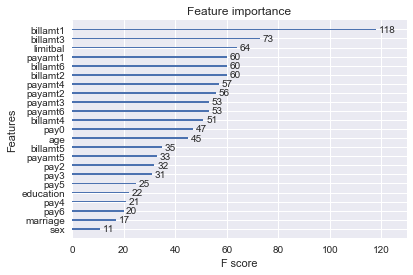

In [112]:

# plot feature importance
plot_importance(alg)


In [47]:
alg.get_booster().get_fscore()

{'Fare': 231,
 'Parch': 91,
 'male': 42,
 'Pclass': 81,
 'SibSp': 86,
 'S': 43,
 'Q': 37,
 'youngin': 27,
 'Age': 150}